In [ ]:
!pip install pandas numpy matplotlib statsmodels pandas-datareader datetime yfinance scikit-learn PyPortfolioOpt pandas-ta

In [ ]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

## 1. Fetching S&P 500 Stock Data  
**Goal**: Get historical OHLCV data for clustering.  
**Theory**:  
- **Yahoo Finance (`yfinance`)** provides free stock data.  
- **Liquidity Filter**: Focus on top 150 stocks by dollar volume to avoid illiquid assets.

In [ ]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

In [ ]:
sp500['Symbol'] = sp500['Symbol'].str.replace('.','- ')

In [ ]:
symbols_list = sp500['Symbol'].unique().tolist()

In [ ]:
end_date = '2024-11-29'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

In [ ]:
df = yf.download(tickers = symbols_list , start = start_date , end = end_date )

[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BF- B', 'BRK- B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


In [ ]:
df

Price        Adj Close                                                  \
Ticker               A        AAPL        ABBV        ABNB         ABT   
Date                                                                     
2016-12-01   40.540226   25.349987   41.960171         NaN   32.533440   
2016-12-02   41.309574   25.444908   42.151680         NaN   32.793022   
2016-12-05   41.778667   25.262005   43.165928         NaN   33.251614   
2016-12-06   42.069515   25.456484   43.704964         NaN   33.242958   
2016-12-07   42.210255   25.706539   42.548862         NaN   33.294868   
...                ...         ...         ...         ...         ...   
2024-11-21  131.816360  228.520004  171.729996  133.259995  117.260002   
2024-11-22  133.593063  229.869995  176.949997  137.339996  117.760002   
2024-11-25  134.241882  232.869995  177.059998  140.929993  118.129997   
2024-11-26  134.122086  235.059998  181.139999  139.669998  117.959999   
2024-11-27  137.885132  234.929993  183.080002  138.279999  118.949997   

Price                                                                  ...  \
Ticker            ACGL         ACN        ADBE         ADI        ADM  ...   
Date                                                                   ...   
2016-12-01   27.766666  103.953987   99.510002   59.180817  35.578110  ...   
2016-12-02   27.696667  103.627052   99.730003   60.124146  35.329201  ...   
2016-12-05   27.983334  104.006966  101.949997   60.544346  35.248886  ...   
2016-12-06   28.146667  104.616577  101.550003   60.887375  35.875195  ...   
2016-12-07   28.293333  107.408516  103.360001   62.551075  36.292721  ...   
...                ...         ...         ...         ...        ...  ...   
2024-11-21   98.589996  361.049988  504.440002  213.057892  53.189999  ...   
2024-11-22   99.690002  358.660004  512.150024  213.685211  53.130001  ...   
2024-11-25  100.059998  361.290009  518.729980  222.637314  53.009998  ...   
2024-11-26  100.410004  363.179993  525.299988  218.126419  53.720001  ...   
2024-11-27  100.739998  362.160004  513.679993  216.254349  54.369999  ...   

Price        Volume                                                         \
Ticker          WTW       WY     WYNN      XEL       XOM      XYL      YUM   
Date                                                                         
2016-12-01   898700  2959100  3881900  2285100  13005600  1734000  3354100   
2016-12-02   855800  2819700  1955500  2692200   9706600   912600  2047800   
2016-12-05   604700  2970600  1678600  1846000  11741100  1212200  2280900   
2016-12-06  1301200  3399000  2892100  2103900  11293600  1474000  2884000   
2016-12-07   928300  5722100  1769500  3076300  11182600  1982000  2655000   
...             ...      ...      ...      ...       ...      ...      ...   
2024-11-21   615800  2763400  1612700  2644900  14675400  1686200  1031100   
2024-11-22   525700  2514100  1620000  2065300  13323400  1365600   992500   
2024-11-25  1118600  7706000  3055000  3122400  26580300  4258900  3604600   
2024-11-26   641600  2365400  1807500  3155900  14827300  1536300  1805700   
2024-11-27  1204700  2785100  1436600  2528400  11079100  1225200  1614100   

Price                                 
Ticker          ZBH    ZBRA      ZTS  
Date                                  
2016-12-01  1594234  640800  4252000  
2016-12-02  1189650  366100  3182800  
2016-12-05  1843700  532700  2578200  
2016-12-06  2065253  350900  2573000  
2016-12-07  1605564  465600  4037800  
...             ...     ...      ...  
2024-11-21  1508200  368400  2019500  
2024-11-22  2015000  232000  1854600  
2024-11-25  2028400  420200  4558300  
2024-11-26  1043800  369200  2539600  
2024-11-27  1246000  258300  2315800  

[2011 rows x 3018 columns]

In [ ]:
 df = df.stack()

In [ ]:
df.index.names = ['date', 'ticker']

In [ ]:
 df.columns = df.columns.str.lower()

## 2. Calculating Technical Indicators  
**Key Features**:  
- **RSI (Relative Strength Index)**: Momentum indicator (overbought/oversold).  
- **Bollinger Bands**: Volatility bands around moving average.  
- **ATR (Average True Range)**: Market volatility measure.  



In [ ]:
df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2) / 2 - \
                         (2 * np.log(2) - 1) * (np.log(df['adj close']) - np.log(df['open']))**2

In [ ]:
df['rsi'] = df.groupby(level = 1)['adj close'].transform(lambda x : pandas_ta.rsi(close=x,length=20))

<Axes: xlabel='date'>

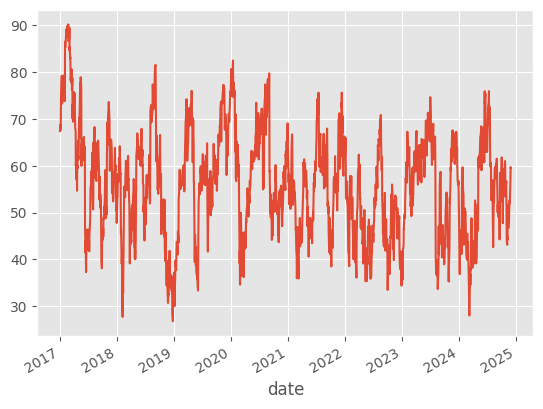

In [ ]:
df.xs('AAPL',level = 1 )['rsi'].plot()

In [ ]:
df['bb_low'] = df.groupby(level = 1)['adj close'].transform(lambda x : pandas_ta.bbands(close=np.log1p(x) ,length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level = 1)['adj close'].transform(lambda x : pandas_ta.bbands(close=np.log1p(x) ,length=20).iloc[:,0])

df['bb_high'] = df.groupby(level = 1)['adj close'].transform(lambda x : pandas_ta.bbands(close=np.log1p(x) ,length=20).iloc[:,0])

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-12-01 A        40.540226   43.209999   44.099998   42.919998   44.080002   
           AAPL     25.349987   27.372499   27.735001   27.257500   27.592501   
           ABBV     41.960171   59.160000   60.830002   58.750000   60.830002   
           ABT      32.533440   37.599998   38.299999   37.380001   38.119999   
           ACGL     27.766666   27.766666   27.906668   27.633333   27.696667   
...                       ...         ...         ...         ...         ...   
2024-11-27 XYL     125.610001  125.610001  127.080002  124.930000  125.440002   
           YUM     138.658112  139.330002  139.979996  138.690002  138.820007   
           ZBH     111.768433  112.019997  112.660004  110.510002  110.839996   
           ZBRA    405.750000  405.750000  406.140015  400.929993  403.730011   
           ZTS     176.740005  176.740005  179.270004  175.000000  175.270004   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-12-01 A         2823100.0         -0.002339        NaN       NaN   
           AAPL    148347600.0         -0.002625        NaN       NaN   
           ABBV      8266200.0         -0.052669        NaN       NaN   
           ABT       9008500.0         -0.009405        NaN       NaN   
           ACGL      1493700.0          0.000046        NaN       NaN   
...                        ...               ...        ...       ...   
2024-11-27 XYL       1225200.0          0.000145  46.850697  4.790608   
           YUM       1614100.0          0.000042  59.903511  4.875754   
           ZBH       1246000.0          0.000159  57.638627  4.676076   
           ZBRA       258300.0          0.000074  64.784457  5.929678   
           ZTS       2315800.0          0.000264  45.104914  5.151740   

Price                bb_mid   bb_high  
date       ticker                      
2016-12-01 A            NaN       NaN  
           AAPL         NaN       NaN  
           ABBV         NaN       NaN  
           ABT          NaN       NaN  
           ACGL         NaN       NaN  
...                     ...       ...  
2024-11-27 XYL     4.790608  4.790608  
           YUM     4.875754  4.875754  
           ZBH     4.676076  4.676076  
           ZBRA    5.929678  5.929678  
           ZTS     5.151740  5.151740  

[987273 rows x 11 columns]

In [ ]:
def compute_atr(stock_data):
  atr = pandas_ta.atr(high = stock_data['high'],low=stock_data['low'],close=stock_data['close'],length = 14)

  return atr.sub(atr.mean()).div(atr.std())


In [ ]:
df['atr'] = df.groupby(level = 1,group_keys = False).apply(compute_atr)
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-12-01 A        40.540226   43.209999   44.099998   42.919998   44.080002   
           AAPL     25.349987   27.372499   27.735001   27.257500   27.592501   
           ABBV     41.960171   59.160000   60.830002   58.750000   60.830002   
           ABT      32.533440   37.599998   38.299999   37.380001   38.119999   
           ACGL     27.766666   27.766666   27.906668   27.633333   27.696667   
...                       ...         ...         ...         ...         ...   
2024-11-27 XYL     125.610001  125.610001  127.080002  124.930000  125.440002   
           YUM     138.658112  139.330002  139.979996  138.690002  138.820007   
           ZBH     111.768433  112.019997  112.660004  110.510002  110.839996   
           ZBRA    405.750000  405.750000  406.140015  400.929993  403.730011   
           ZTS     176.740005  176.740005  179.270004  175.000000  175.270004   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-12-01 A         2823100.0         -0.002339        NaN       NaN   
           AAPL    148347600.0         -0.002625        NaN       NaN   
           ABBV      8266200.0         -0.052669        NaN       NaN   
           ABT       9008500.0         -0.009405        NaN       NaN   
           ACGL      1493700.0          0.000046        NaN       NaN   
...                        ...               ...        ...       ...   
2024-11-27 XYL       1225200.0          0.000145  46.850697  4.790608   
           YUM       1614100.0          0.000042  59.903511  4.875754   
           ZBH       1246000.0          0.000159  57.638627  4.676076   
           ZBRA       258300.0          0.000074  64.784457  5.929678   
           ZTS       2315800.0          0.000264  45.104914  5.151740   

Price                bb_mid   bb_high       atr  
date       ticker                                
2016-12-01 A            NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN  
           ABT          NaN       NaN       NaN  
           ACGL         NaN       NaN       NaN  
...                     ...       ...       ...  
2024-11-27 XYL     4.790608  4.790608  0.851632  
           YUM     4.875754  4.875754  0.662735  
           ZBH     4.676076  4.676076 -0.614592  
           ZBRA    5.929678  5.929678 -0.064904  
           ZTS     5.151740  5.151740  0.607275  

[987273 rows x 12 columns]

In [ ]:
def compute_macd(close):
  macd = pandas_ta.macd(close = close , length = 20).iloc[:,0]
  return macd.sub(macd.mean()).div(macd.std())

In [ ]:
df['macd'] = df.groupby(level = 1,group_keys = False)['adj close'].apply(compute_macd)


In [ ]:
df['dollar volume'] = (df['adj close']*df['volume'])/1e6
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-12-01 A        40.540226   43.209999   44.099998   42.919998   44.080002   
           AAPL     25.349987   27.372499   27.735001   27.257500   27.592501   
           ABBV     41.960171   59.160000   60.830002   58.750000   60.830002   
           ABT      32.533440   37.599998   38.299999   37.380001   38.119999   
           ACGL     27.766666   27.766666   27.906668   27.633333   27.696667   
...                       ...         ...         ...         ...         ...   
2024-11-27 XYL     125.610001  125.610001  127.080002  124.930000  125.440002   
           YUM     138.658112  139.330002  139.979996  138.690002  138.820007   
           ZBH     111.768433  112.019997  112.660004  110.510002  110.839996   
           ZBRA    405.750000  405.750000  406.140015  400.929993  403.730011   
           ZTS     176.740005  176.740005  179.270004  175.000000  175.270004   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-12-01 A         2823100.0         -0.002339        NaN       NaN   
           AAPL    148347600.0         -0.002625        NaN       NaN   
           ABBV      8266200.0         -0.052669        NaN       NaN   
           ABT       9008500.0         -0.009405        NaN       NaN   
           ACGL      1493700.0          0.000046        NaN       NaN   
...                        ...               ...        ...       ...   
2024-11-27 XYL       1225200.0          0.000145  46.850697  4.790608   
           YUM       1614100.0          0.000042  59.903511  4.875754   
           ZBH       1246000.0          0.000159  57.638627  4.676076   
           ZBRA       258300.0          0.000074  64.784457  5.929678   
           ZTS       2315800.0          0.000264  45.104914  5.151740   

Price                bb_mid   bb_high       atr      macd  dollar volume  
date       ticker                                                         
2016-12-01 A            NaN       NaN       NaN       NaN     114.449112  
           AAPL         NaN       NaN       NaN       NaN    3760.609736  
           ABBV         NaN       NaN       NaN       NaN     346.851163  
           ABT          NaN       NaN       NaN       NaN     293.077491  
           ACGL         NaN       NaN       NaN       NaN      41.475070  
...                     ...       ...       ...       ...            ...  
2024-11-27 XYL     4.790608  4.790608  0.851632 -0.767523     153.897373  
           YUM     4.875754  4.875754  0.662735  0.340966     223.808058  
           ZBH     4.676076  4.676076 -0.614592  0.497738     139.263467  
           ZBRA    5.929678  5.929678 -0.064904  0.715433     104.805225  
           ZTS     5.151740  5.151740  0.607275 -0.973664     409.294505  

[987273 rows x 14 columns]

**3. Aggregate to monthly level and find top 150 liquid stocks**


---



In [ ]:
last_cols=  [c for c in df.columns.unique(0) if c not in ['dollar volume','volume','close','open','high','low','close'] ]


In [ ]:
dollar_volume_resampled = (
    df.unstack('ticker')['dollar volume']
    .resample('M')
    .mean()
    .stack('ticker')
    .to_frame('dollar volume')
)

last_resampled = (
    df.unstack()[last_cols]
    .resample('M')
    .last()
    .stack('ticker')
)

data = pd.concat([dollar_volume_resampled, last_resampled], axis=1).dropna()

In [ ]:
data['dollar volume'] = (data.loc[:,'dollar volume'].unstack('ticker').rolling(5*12,min_periods=12).mean().stack())
data

dollar volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-01-31 A                 NaN   46.077381         -0.000397  62.393097   
           AAPL              NaN   28.095901         -0.002159  73.756121   
           ABBV              NaN   43.780571         -0.038072  50.339157   
           ABT               NaN   36.375000         -0.004523  74.600032   
           ACGL              NaN   29.450001          0.000141  60.681179   
...                          ...         ...               ...        ...   
2024-11-30 KVUE       435.056911   24.129999          0.000103  61.729318   
           VLTO       151.467610  107.853577          0.000033  54.276389   
           GEV               NaN  335.078094          0.000398  60.894435   
           SOLV              NaN   72.480003          0.000171  57.208941   
           SW                NaN   54.759998          0.000205  61.906140   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2017-01-31 A       3.801789  3.801789  3.801789 -1.388148  0.142285  
           AAPL    3.327728  3.327728  3.327728 -1.452312 -0.132373  
           ABBV    3.779777  3.779777  3.779777 -1.447146 -0.307038  
           ABT     3.557928  3.557928  3.557928 -1.416147  0.225345  
           ACGL    3.379891  3.379891  3.379891 -1.171884 -0.043747  
...                     ...       ...       ...       ...       ...  
2024-11-30 KVUE    3.159425  3.159425  3.159425 -0.051407  1.134619  
           VLTO    4.620465  4.620465  4.620465 -0.107052 -0.722872  
           GEV     5.705561  5.705561  5.705561  3.452456  0.857399  
           SOLV    4.211054  4.211054  4.211054 -0.661524 -0.184630  
           SW      3.918795  3.918795  3.918795  0.845387  1.439764  

[46633 rows x 9 columns]

In [ ]:
data['dollar volume rank'] = data.groupby('date')['dollar volume'].rank(ascending=False)
data

dollar volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-01-31 A                 NaN   46.077381         -0.000397  62.393097   
           AAPL              NaN   28.095901         -0.002159  73.756121   
           ABBV              NaN   43.780571         -0.038072  50.339157   
           ABT               NaN   36.375000         -0.004523  74.600032   
           ACGL              NaN   29.450001          0.000141  60.681179   
...                          ...         ...               ...        ...   
2024-11-30 KVUE       435.056911   24.129999          0.000103  61.729318   
           VLTO       151.467610  107.853577          0.000033  54.276389   
           GEV               NaN  335.078094          0.000398  60.894435   
           SOLV              NaN   72.480003          0.000171  57.208941   
           SW                NaN   54.759998          0.000205  61.906140   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2017-01-31 A       3.801789  3.801789  3.801789 -1.388148  0.142285   
           AAPL    3.327728  3.327728  3.327728 -1.452312 -0.132373   
           ABBV    3.779777  3.779777  3.779777 -1.447146 -0.307038   
           ABT     3.557928  3.557928  3.557928 -1.416147  0.225345   
           ACGL    3.379891  3.379891  3.379891 -1.171884 -0.043747   
...                     ...       ...       ...       ...       ...   
2024-11-30 KVUE    3.159425  3.159425  3.159425 -0.051407  1.134619   
           VLTO    4.620465  4.620465  4.620465 -0.107052 -0.722872   
           GEV     5.705561  5.705561  5.705561  3.452456  0.857399   
           SOLV    4.211054  4.211054  4.211054 -0.661524 -0.184630   
           SW      3.918795  3.918795  3.918795  0.845387  1.439764   

                   dollar volume rank  
date       ticker                      
2017-01-31 A                      NaN  
           AAPL                   NaN  
           ABBV                   NaN  
           ABT                    NaN  
           ACGL                   NaN  
...                               ...  
2024-11-30 KVUE                 115.0  
           VLTO                 340.0  
           GEV                    NaN  
           SOLV                   NaN  
           SW                     NaN  

[46633 rows x 10 columns]

In [ ]:
data =  data[data['dollar volume rank']<150 ]

In [ ]:
data

dollar volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-12-31 AAPL      3807.690645   39.811539         -0.001775  47.784591   
           ABBV       326.261327   71.096039         -0.039988  55.000972   
           ABT        279.405616   50.525520         -0.006559  59.877809   
           ACN        242.288644  137.983673         -0.004850  65.003827   
           ADBE       357.206540  175.240005          0.000056  51.008422   
...                          ...         ...               ...        ...   
2024-11-30 UBER      1057.668029   71.620003          0.000262  45.848616   
           CRWD       838.922609  347.589996          0.001011  58.367398   
           PLTR      1144.798480   66.050003          0.001266  73.082156   
           ABNB       830.464935  138.279999          0.000154  54.313030   
           KVUE       435.056911   24.129999          0.000103  61.729318   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2017-12-31 AAPL    3.698682  3.698682  3.698682 -1.261704 -0.269846   
           ABBV    4.253741  4.253741  4.253741 -0.925255  0.080755   
           ABT     3.884984  3.884984  3.884984 -1.377113  0.163123   
           ACN     4.891671  4.891671  4.891671 -1.165642  0.224079   
           ADBE    5.137116  5.137116  5.137116 -1.358737 -0.179795   
...                     ...       ...       ...       ...       ...   
2024-11-30 UBER    4.246137  4.246137  4.246137  0.991787 -1.032304   
           CRWD    5.692371  5.692371  5.692371  1.235961  1.758262   
           PLTR    3.776450  3.776450  3.776450  2.983459  4.532406   
           ABNB    4.868597  4.868597  4.868597 -0.760161  0.270591   
           KVUE    3.159425  3.159425  3.159425 -0.051407  1.134619   

                   dollar volume rank  
date       ticker                      
2017-12-31 AAPL                   1.0  
           ABBV                  71.0  
           ABT                   89.0  
           ACN                  110.0  
           ADBE                  63.0  
...                               ...  
2024-11-30 UBER                  35.0  
           CRWD                  45.0  
           PLTR                  31.0  
           ABNB                  47.0  
           KVUE                 115.0  

[12516 rows x 10 columns]

**4. calculating returns in different time horizon**


---



In [ ]:
def calculate_returns(df):
    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]
    for lag in lags:
        df[f'return_{lag}m'] = (
            df['adj close']
            .pct_change(lag)
            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff), upper=x.quantile(1-outlier_cutoff)))
            .add(1)
            .pow(1/lag)
            .sub(1)
        )
    return df

# Apply the function
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

In [ ]:
data

dollar volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2018-12-31 AAPL      4940.057595   37.665627         -0.000835  37.072855   
           ABBV       422.584119   70.416008         -0.026539  57.957272   
           ABT        321.268633   65.209167         -0.003189  55.190192   
           ACN        286.233097  129.389069         -0.002485  36.633842   
           ADBE       566.471662  226.240005          0.000161  46.330419   
...                          ...         ...               ...        ...   
2024-11-30 MRNA      1356.439914   43.389999          0.000351  38.350531   
           UBER      1057.668029   71.620003          0.000262  45.848616   
           CRWD       838.922609  347.589996          0.001011  58.367398   
           PLTR      1144.798480   66.050003          0.001266  73.082156   
           ABNB       830.464935  138.279999          0.000154  54.313030   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2018-12-31 AAPL    3.585046  3.585046  3.585046 -0.675944 -1.246865   
           ABBV    4.152361  4.152361  4.152361  0.740392 -0.098671   
           ABT     4.111693  4.111693  4.111693  0.306206 -0.323602   
           ACN     4.807611  4.807611  4.807611 -0.154613 -1.467050   
           ADBE    5.329066  5.329066  5.329066 -0.045763 -0.755888   
...                     ...       ...       ...       ...       ...   
2024-11-30 MRNA    3.550437  3.550437  3.550437 -0.699360 -0.473650   
           UBER    4.246137  4.246137  4.246137  0.991787 -1.032304   
           CRWD    5.692371  5.692371  5.692371  1.235961  1.758262   
           PLTR    3.776450  3.776450  3.776450  2.983459  4.532406   
           ABNB    4.868597  4.868597  4.868597 -0.760161  0.270591   

                   dollar volume rank  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-12-31 AAPL                   2.0  -0.116698  -0.132912  -0.101245   
           ABBV                  61.0  -0.022064   0.088210  -0.004972   
           ABT                   85.0  -0.023227   0.024292  -0.003340   
           ACN                  102.0  -0.142900  -0.054156  -0.057936   
           ADBE                  39.0  -0.098250  -0.040535  -0.057180   
...                               ...        ...        ...        ...   
2024-11-30 MRNA                  24.0  -0.201803  -0.194234  -0.175451   
           UBER                  35.0  -0.005968  -0.023834  -0.006931   
           CRWD                  45.0   0.170849   0.113244   0.078242   
           PLTR                  31.0   0.589269   0.332493   0.280205   
           ABNB                  47.0   0.025892   0.044246   0.056351   

                   return_6m  return_9m  return_12m  
date       ticker                                    
2018-12-31 AAPL    -0.025181  -0.005637   -0.004607  
           ABBV     0.002641   0.000530   -0.000801  
           ABT      0.030303   0.022655    0.021488  
           ACN     -0.022971  -0.007415   -0.005345  
           ADBE    -0.012388   0.005118    0.021515  
...                      ...        ...         ...  
2024-11-30 MRNA    -0.170918  -0.080381   -0.047392  
           UBER     0.017447  -0.011531    0.020138  
           CRWD     0.017261   0.007788    0.032432  
           PLTR     0.198902   0.113262    0.104118  
           ABNB    -0.007798  -0.014336    0.007554  

[10364 rows x 16 columns]

**5. Download FFF data and calculate rolling betas**



---



In [ ]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
               'famafrench',
               start = '2010')[0].drop('RF',axis=1)

In [ ]:
 factor_data.index = factor_data.index.to_timestamp()

In [ ]:
factor_data = factor_data.resample('M').last().divide(100)

In [ ]:
factor_data.index.name = 'date'


In [ ]:
factor_data = factor_data.join(data['return_1m']).sort_index()

In [ ]:
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations>10]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-12-31 AAPL   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.116698
           ABBV   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.022064
           ABT    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.023227
           ACN    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.142900
           ADBE   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.098250
...                   ...     ...     ...     ...     ...        ...
2024-11-30 VZ      0.0650  0.0478 -0.0005 -0.0261 -0.0217   0.053406
           WDAY    0.0650  0.0478 -0.0005 -0.0261 -0.0217   0.083601
           WFC     0.0650  0.0478 -0.0005 -0.0261 -0.0217   0.196163
           WMT     0.0650  0.0478 -0.0005 -0.0261 -0.0217   0.121171
           XOM     0.0650  0.0478 -0.0005 -0.0261 -0.0217   0.007536

[10326 rows x 6 columns]

CALCULATE ROLLING FACTOR BETAS


In [ ]:


# Calculate rolling betas
betas = (
    factor_data
    .groupby(level=1, group_keys=False)  # Group by the second level (e.g., ticker)
    .apply(
        lambda x: RollingOLS(
            endog=x['return_1m'],  # Dependent variable
            exog=sm.add_constant(x.drop('return_1m', axis=1)),  # Independent variables + constant
            window=min(24, x.shape[0]),  # Rolling window size
            min_nobs=len(x.columns) + 1  # Minimum observations for regression
        )
        .fit(params_only=True)  # Fit regression and retain only parameters
        .params
        .drop('const', axis=1)  # Drop the intercept term
    )
)

In [ ]:
betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-12-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-11-30 VZ      0.885977 -0.605732  0.298681  0.504491  0.276253
           WDAY    0.768063 -1.005863  0.144871 -2.508158 -0.731989
           WFC     0.731860 -0.292608  1.422094 -2.033350 -1.098550
           WMT     0.838331  0.169956 -0.327239  1.289680  0.289604
           XOM     0.608775  0.018004  0.210636  1.193470  0.730326

[10326 rows x 5 columns]

In [ ]:
data = (data.join(betas.groupby('ticker').shift()))

data

dollar volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2018-12-31 AAPL      4940.057595   37.665627         -0.000835  37.072855   
           ABBV       422.584119   70.416008         -0.026539  57.957272   
           ABT        321.268633   65.209167         -0.003189  55.190192   
           ACN        286.233097  129.389069         -0.002485  36.633842   
           ADBE       566.471662  226.240005          0.000161  46.330419   
...                          ...         ...               ...        ...   
2024-11-30 MRNA      1356.439914   43.389999          0.000351  38.350531   
           UBER      1057.668029   71.620003          0.000262  45.848616   
           CRWD       838.922609  347.589996          0.001011  58.367398   
           PLTR      1144.798480   66.050003          0.001266  73.082156   
           ABNB       830.464935  138.279999          0.000154  54.313030   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2018-12-31 AAPL    3.585046  3.585046  3.585046 -0.675944 -1.246865   
           ABBV    4.152361  4.152361  4.152361  0.740392 -0.098671   
           ABT     4.111693  4.111693  4.111693  0.306206 -0.323602   
           ACN     4.807611  4.807611  4.807611 -0.154613 -1.467050   
           ADBE    5.329066  5.329066  5.329066 -0.045763 -0.755888   
...                     ...       ...       ...       ...       ...   
2024-11-30 MRNA    3.550437  3.550437  3.550437 -0.699360 -0.473650   
           UBER    4.246137  4.246137  4.246137  0.991787 -1.032304   
           CRWD    5.692371  5.692371  5.692371  1.235961  1.758262   
           PLTR    3.776450  3.776450  3.776450  2.983459  4.532406   
           ABNB    4.868597  4.868597  4.868597 -0.760161  0.270591   

                   dollar volume rank  ...  return_2m  return_3m  return_6m  \
date       ticker                      ...                                    
2018-12-31 AAPL                   2.0  ...  -0.132912  -0.101245  -0.025181   
           ABBV                  61.0  ...   0.088210  -0.004972   0.002641   
           ABT                   85.0  ...   0.024292  -0.003340   0.030303   
           ACN                  102.0  ...  -0.054156  -0.057936  -0.022971   
           ADBE                  39.0  ...  -0.040535  -0.057180  -0.012388   
...                               ...  ...        ...        ...        ...   
2024-11-30 MRNA                  24.0  ...  -0.194234  -0.175451  -0.170918   
           UBER                  35.0  ...  -0.023834  -0.006931   0.017447   
           CRWD                  45.0  ...   0.113244   0.078242   0.017261   
           PLTR                  31.0  ...   0.332493   0.280205   0.198902   
           ABNB                  47.0  ...   0.044246   0.056351  -0.007798   

                   return_9m  return_12m    Mkt-RF       SMB       HML  \
date       ticker                                                        
2018-12-31 AAPL    -0.005637   -0.004607       NaN       NaN       NaN   
           ABBV     0.000530   -0.000801       NaN       NaN       NaN   
           ABT      0.022655    0.021488       NaN       NaN       NaN   
           ACN     -0.007415   -0.005345       NaN       NaN       NaN   
           ADBE     0.005118    0.021515       NaN       NaN       NaN   
...                      ...         ...       ...       ...       ...   
2024-11-30 MRNA    -0.080381   -0.047392  1.289824  1.556821 -0.032658   
           UBER    -0.011531    0.020138  1.980228 -0.763077  0.194882   
           CRWD     0.007788    0.032432  0.468488 -3.650492  1.396670   
           PLTR     0.113262    0.104118  0.658940 -0.250783 -1.530316   
           ABNB    -0.014336    0.007554       NaN       NaN       NaN   

                        RMW       CMA  
date       ticker                      
2018-12-31 AAPL       

In [ ]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data.loc[:,factors] = data.groupby('ticker',group_keys=False)[factors].apply(lambda x : x.fillna(x.mean()))



In [ ]:
 data.dropna()
 data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10364 entries, (Timestamp('2018-12-31 00:00:00'), 'AAPL') to (Timestamp('2024-11-30 00:00:00'), 'ABNB')
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   dollar volume       10364 non-null  float64
 1   adj close           10364 non-null  float64
 2   garman_klass_vol    10364 non-null  float64
 3   rsi                 10364 non-null  float64
 4   bb_low              10364 non-null  float64
 5   bb_mid              10364 non-null  float64
 6   bb_high             10364 non-null  float64
 7   atr                 10364 non-null  float64
 8   macd                10364 non-null  float64
 9   dollar volume rank  10364 non-null  float64
 10  return_1m           10364 non-null  float64
 11  return_2m           10364 non-null  float64
 12  return_3m           10364 non-null  float64
 13  return_6m           10364 non-null  float64
 14  return_9m           1036

In [ ]:
 data = data.drop('adj close' , axis = 1 )

In [ ]:
data = data.drop('dollar volume' , axis = 1 )
data = data.drop('dollar volume rank' , axis = 1 )

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10364 entries, (Timestamp('2018-12-31 00:00:00'), 'AAPL') to (Timestamp('2024-11-30 00:00:00'), 'ABNB')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10364 non-null  float64
 1   rsi               10364 non-null  float64
 2   bb_low            10364 non-null  float64
 3   bb_mid            10364 non-null  float64
 4   bb_high           10364 non-null  float64
 5   atr               10364 non-null  float64
 6   macd              10364 non-null  float64
 7   return_1m         10364 non-null  float64
 8   return_2m         10364 non-null  float64
 9   return_3m         10364 non-null  float64
 10  return_6m         10364 non-null  float64
 11  return_9m         10364 non-null  float64
 12  return_12m        10364 non-null  float64
 13  Mkt-RF            10125 non-null  float64
 14  SMB               10125 non-null  float64
 15  HML      



---



## Clustering Stocks with K-Means  
**Theory**:  
- **Unsupervised Learning**: Groups stocks based on technical features (no labels).  
- **Centroid Initialization**: Predefined RSI values (30, 45, 55, 70) to guide clusters.  





---



In [ ]:
from sklearn.cluster import KMeans

In [ ]:
target_rsi_values = [30,45,55,70]
initial_centroids = np.zeros((len(target_rsi_values), 18))
initial_centroids[:,1]=target_rsi_values
initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [ ]:
def get_clusters(df):

  df['cluster'] = KMeans(n_clusters = 4 , random_state = 0 , init=initial_centroids).fit(df).labels_
  return df

In [ ]:
data = data.dropna().groupby('date',group_keys=False).apply(get_clusters)

In [ ]:
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-12-31 AAPL           -0.000835  37.072855  3.585046  3.585046  3.585046   
           ABBV           -0.026539  57.957272  4.152361  4.152361  4.152361   
           ABT            -0.003189  55.190192  4.111693  4.111693  4.111693   
           ACN            -0.002485  36.633842  4.807611  4.807611  4.807611   
           ADBE            0.000161  46.330419  5.329066  5.329066  5.329066   
...                             ...        ...       ...       ...       ...   
2024-11-30 XOM             0.000055  45.935334  4.763490  4.763490  4.763490   
           MRNA            0.000351  38.350531  3.550437  3.550437  3.550437   
           UBER            0.000262  45.848616  4.246137  4.246137  4.246137   
           CRWD            0.001011  58.367398  5.692371  5.692371  5.692371   
           PLTR            0.001266  73.082156  3.776450  3.776450  3.776450   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-12-31 AAPL   -0.675944 -1.246865  -0.116698  -0.132912  -0.101245   
           ABBV    0.740392 -0.098671  -0.022064   0.088210  -0.004972   
           ABT     0.306206 -0.323602  -0.023227   0.024292  -0.003340   
           ACN    -0.154613 -1.467050  -0.142900  -0.054156  -0.057936   
           ADBE   -0.045763 -0.755888  -0.098250  -0.040535  -0.057180   
...                     ...       ...        ...        ...        ...   
2024-11-30 XOM     0.370303 -0.171438   0.007536   0.001875  -0.000792   
           MRNA   -0.699360 -0.473650  -0.201803  -0.194234  -0.175451   
           UBER    0.991787 -1.032304  -0.005968  -0.023834  -0.006931   
           CRWD    1.235961  1.758262   0.170849   0.113244   0.078242   
           PLTR    2.983459  4.532406   0.589269   0.332493   0.280205   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-12-31 AAPL    -0.025181  -0.005637   -0.004607  1.289316 -0.227871   
           ABBV     0.002641   0.000530   -0.000801  0.533087  0.313190   
           ABT      0.030303   0.022655    0.021488  0.766292 -0.049225   
           ACN     -0.022971  -0.007415   -0.005345  1.200545 -0.203145   
           ADBE    -0.012388   0.005118    0.021515  1.313989 -0.563005   
...                      ...        ...         ...       ...       ...   
2024-11-30 XOM      0.001906   0.015060    0.013503  0.366613 -0.109510   
           MRNA    -0.170918  -0.080381   -0.047392  1.289824  1.556821   
           UBER     0.017447  -0.011531    0.020138  1.980228 -0.763077   
           CRWD     0.017261   0.007788    0.032432  0.468488 -3.650492   
           PLTR     0.198902   0.113262    0.104118  0.658940 -0.250783   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-12-31 AAPL   -0.628085  0.337556  0.477196        3  
           ABBV   -0.145888  0.402109  0.544406        2  
           ABT    -0.438578  0.157058  1.002007        2  
           ACN    -0.225534  0.335007  0.007835        3  
           ADBE   -0.256390  0.315516 -0.425510        1  
...                     ...       ...       ...      ...  
2024-11-30 XOM     0.369962  0.572320  0.339758        1  
           MRNA   -0.032658  2.294941  0.041754        0  
           UBER    0.194882 -1.959429 -1.255806        1  
           CRWD    1.396670 -5.096165 -3.414445        2  
           PLTR   -1.530316 -5.261666 -2.934973        3  

[10125 rows x 19 columns]

In [ ]:

def plot_clusters(data):
    # Extracting data for each cluster
    cluster_0 = data[data['cluster'] == 0]
    cluster_1 = data[data['cluster'] == 1]
    cluster_2 = data[data['cluster'] == 2]
    cluster_3 = data[data['cluster'] == 3]

    # Scatter plot for each cluster
    plt.scatter(cluster_0.iloc[:, 5], cluster_0.iloc[:, 1], color='red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:, 5], cluster_1.iloc[:, 1], color='green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:, 5], cluster_2.iloc[:, 1], color='blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:, 5], cluster_3.iloc[:, 1], color='black', label='cluster 3')

    # Adding legend and displaying the plot
    plt.legend()
    plt.show()

    return

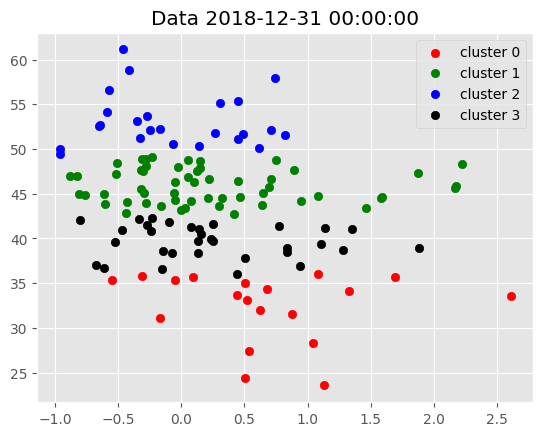

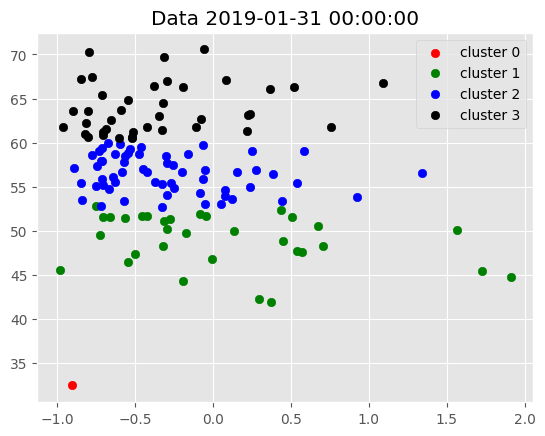

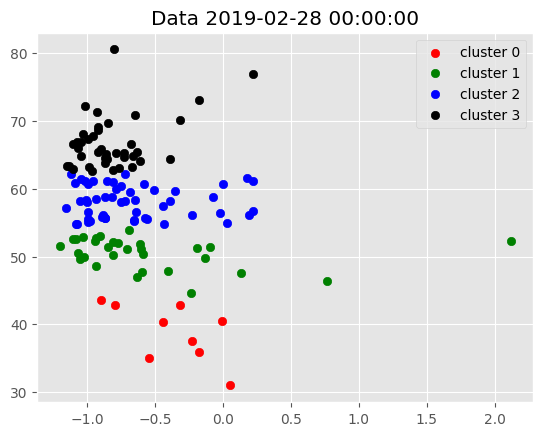

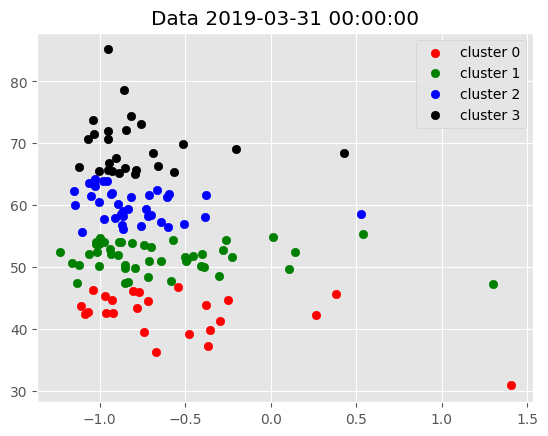

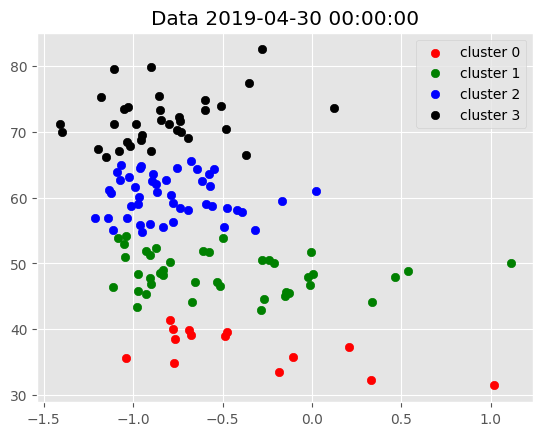

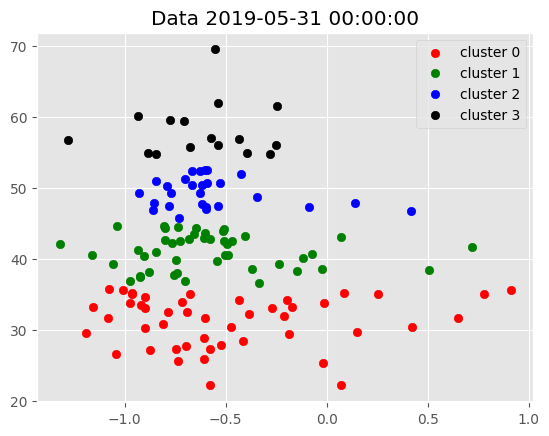

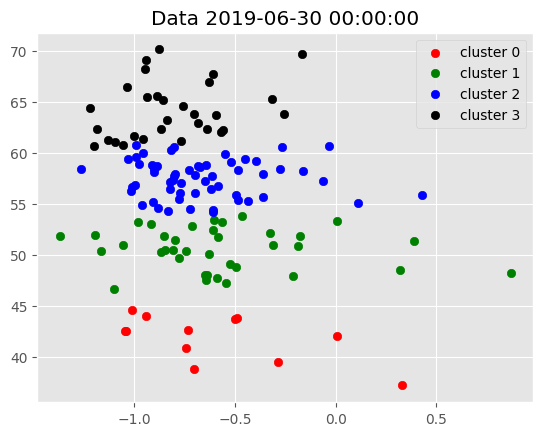

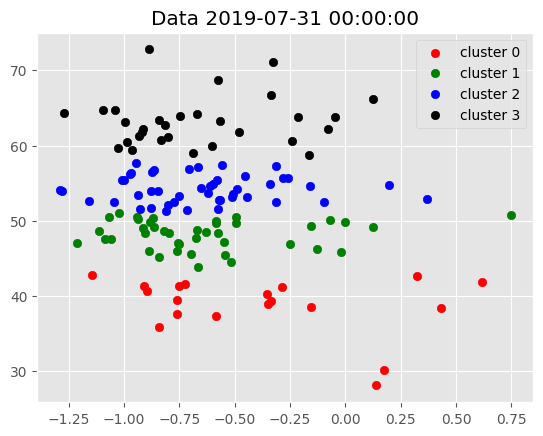

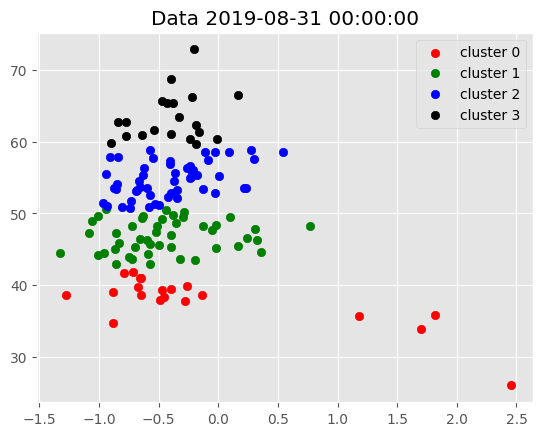

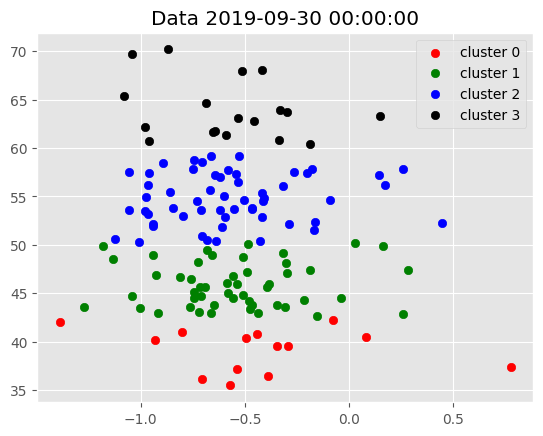

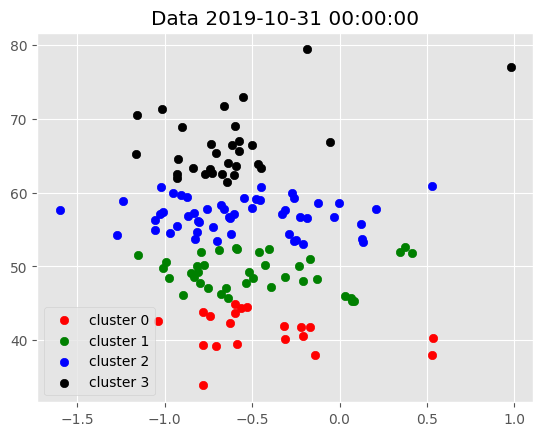

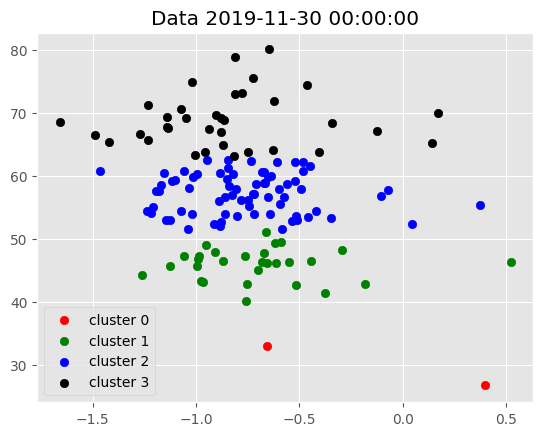

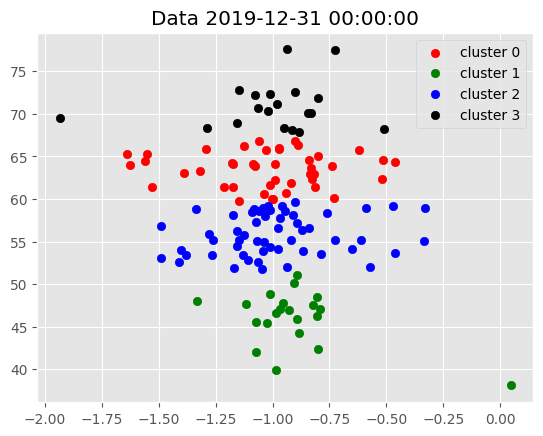

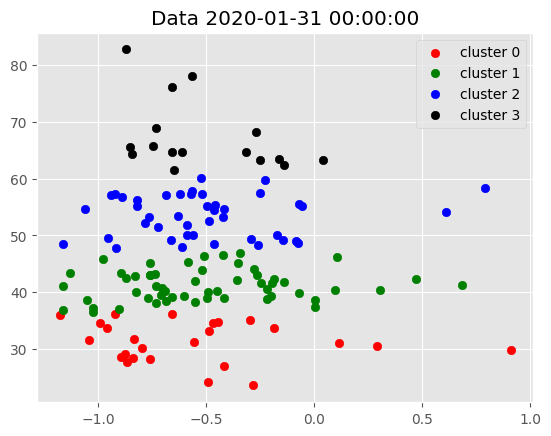

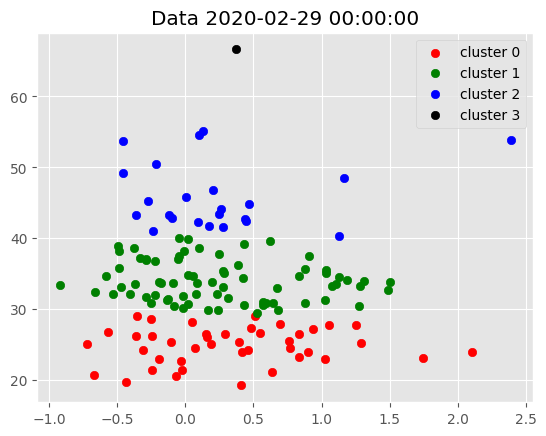

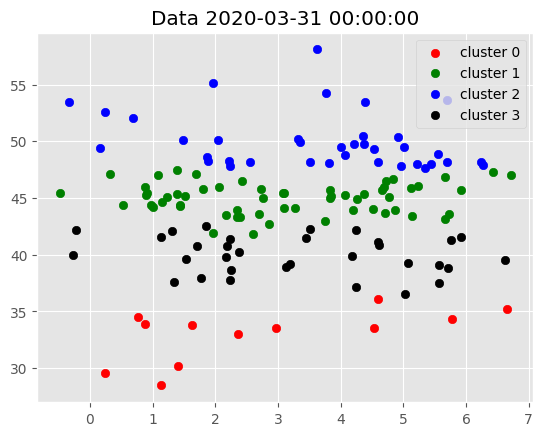

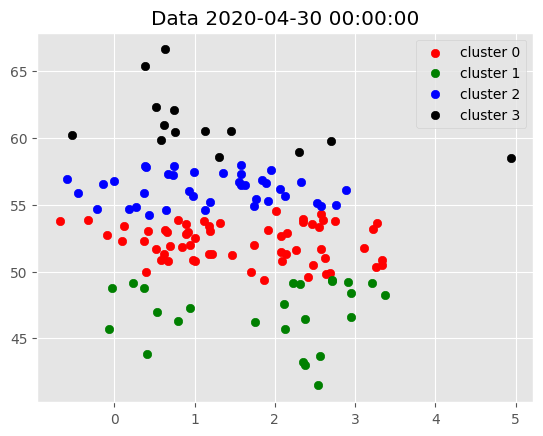

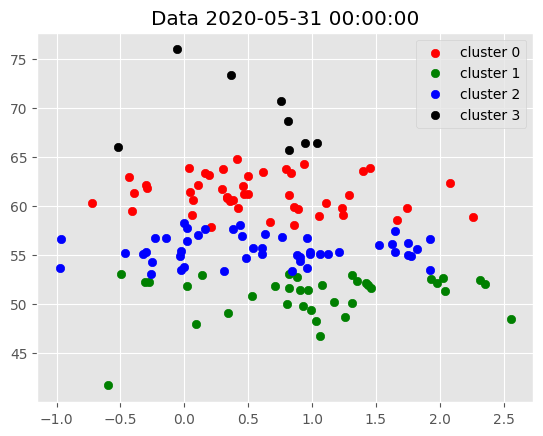

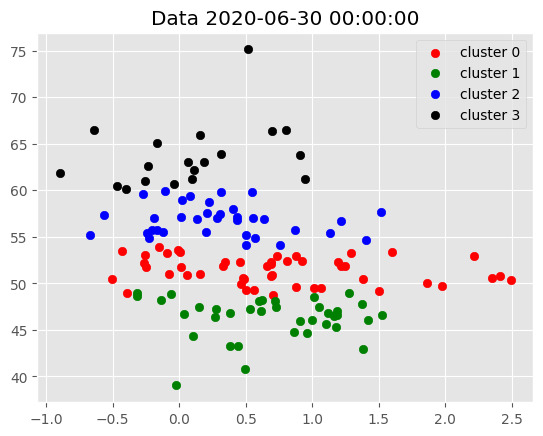

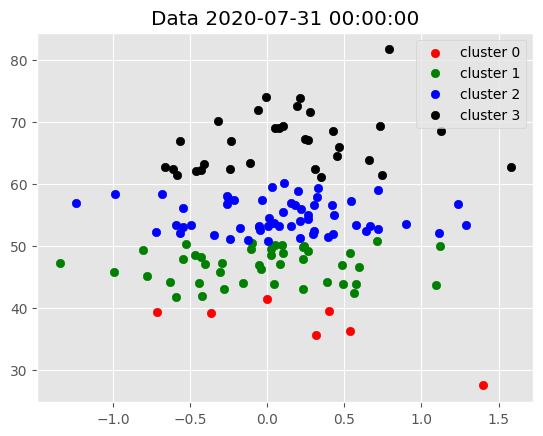

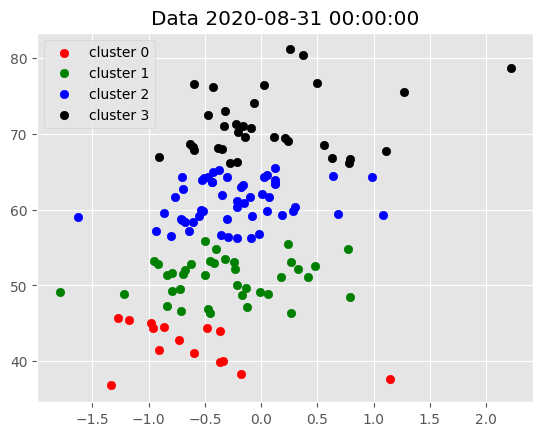

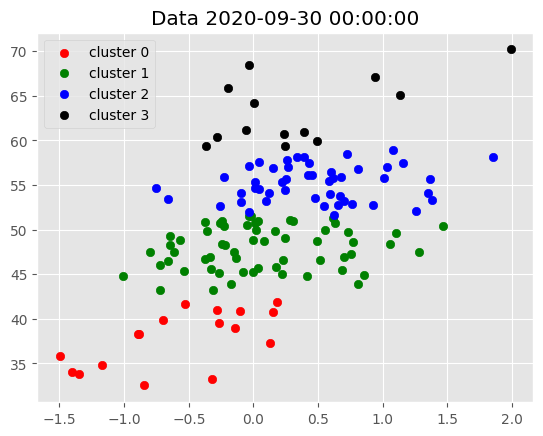

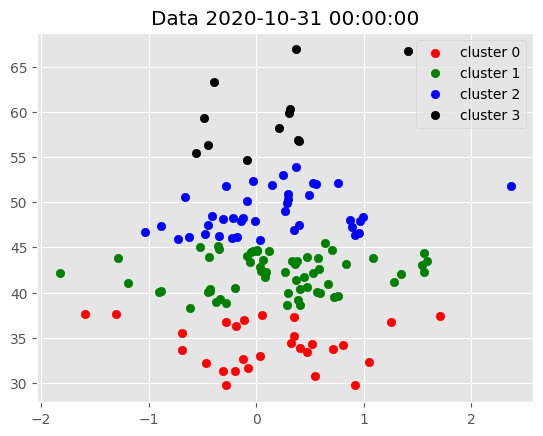

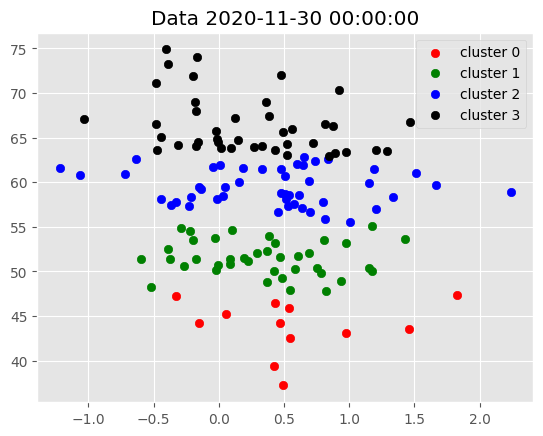

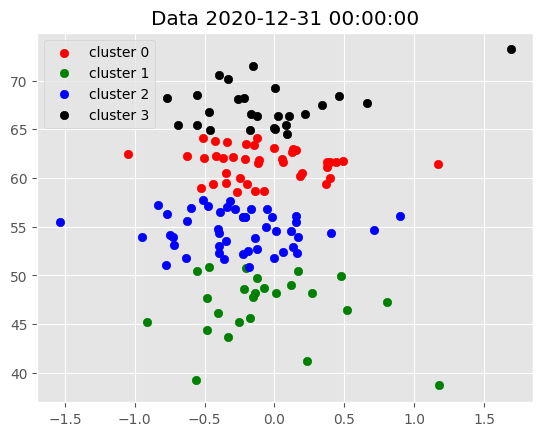

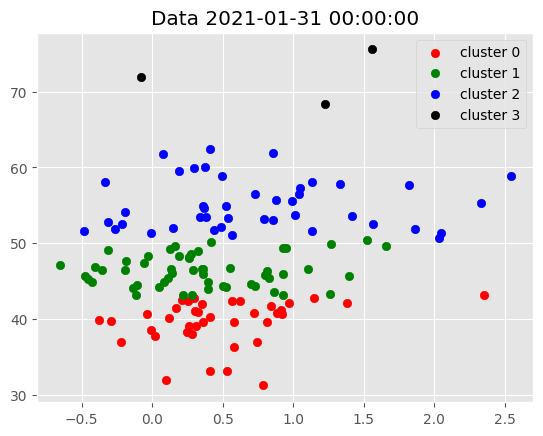

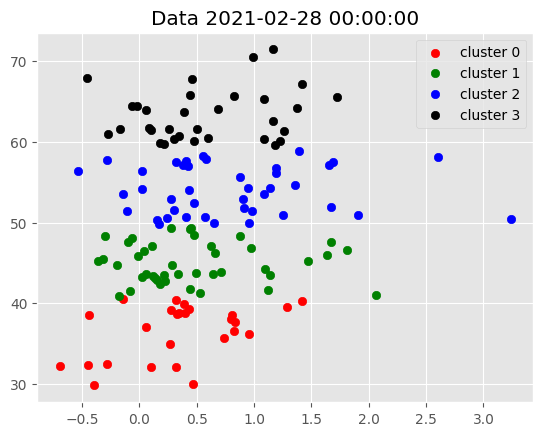

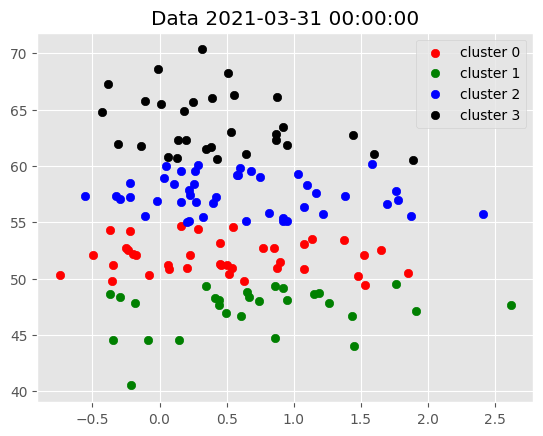

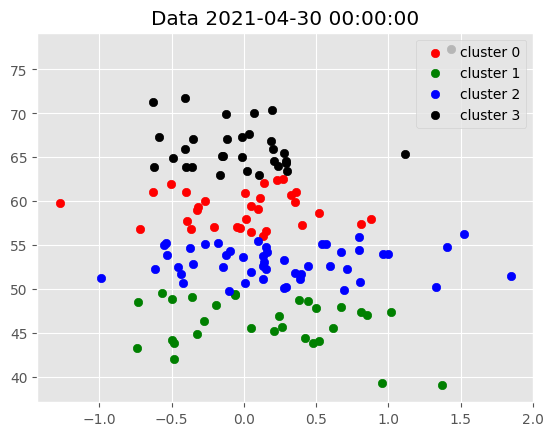

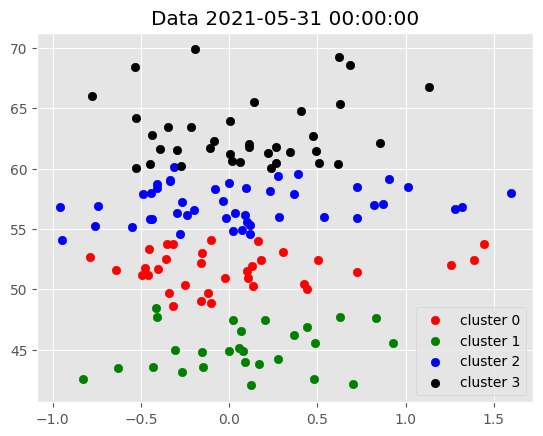

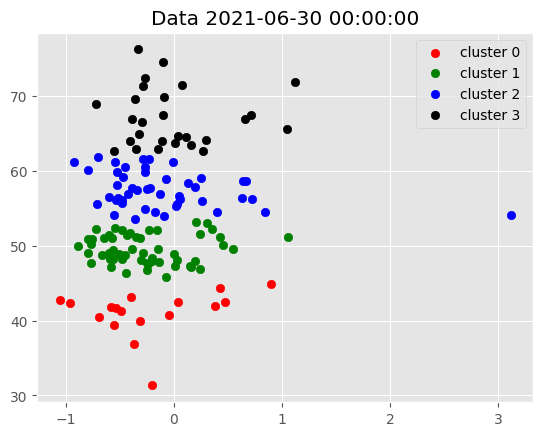

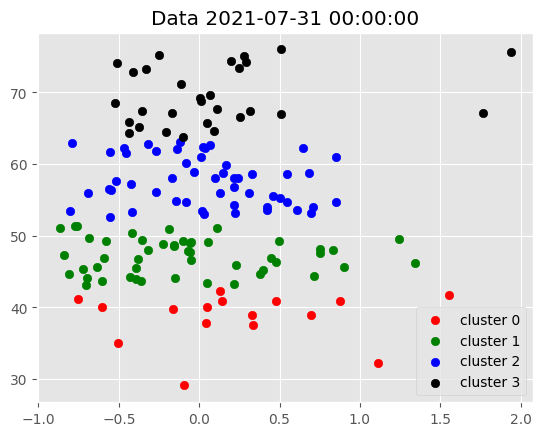

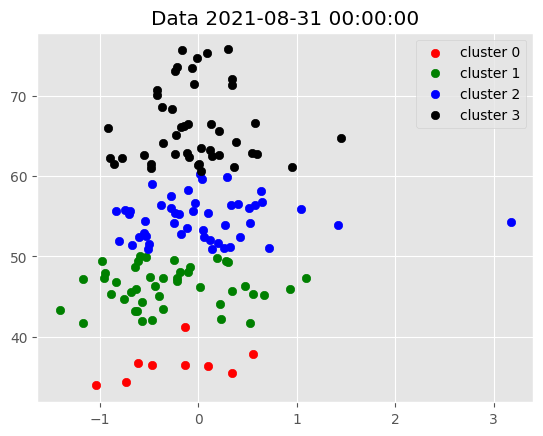

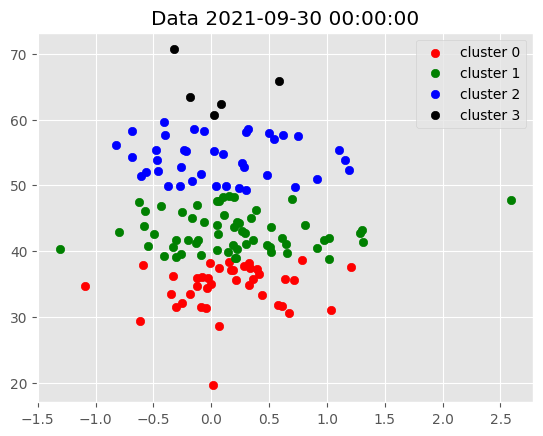

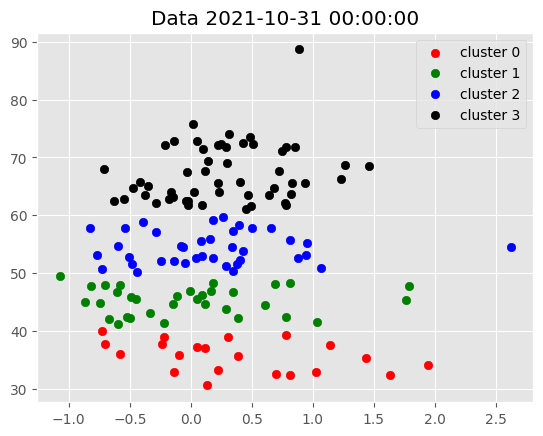

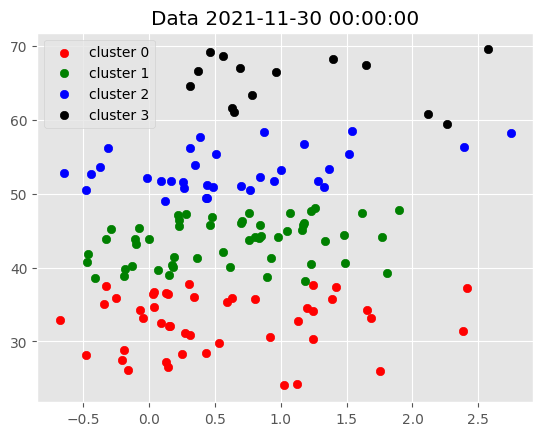

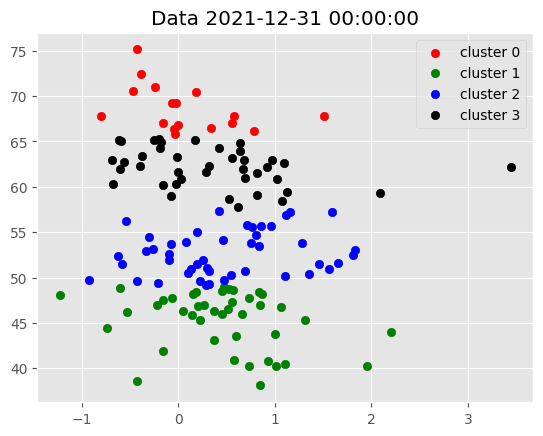

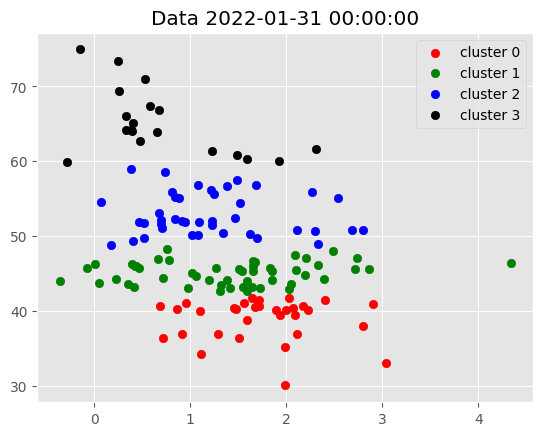

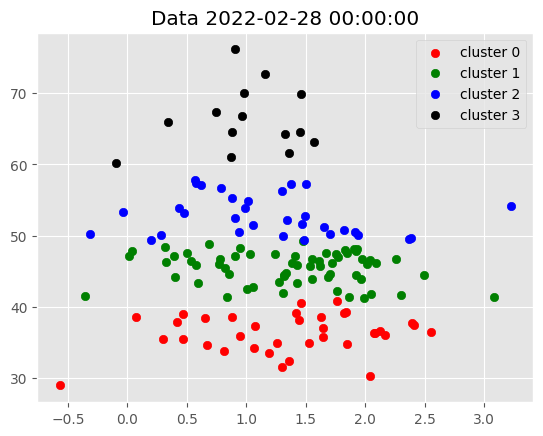

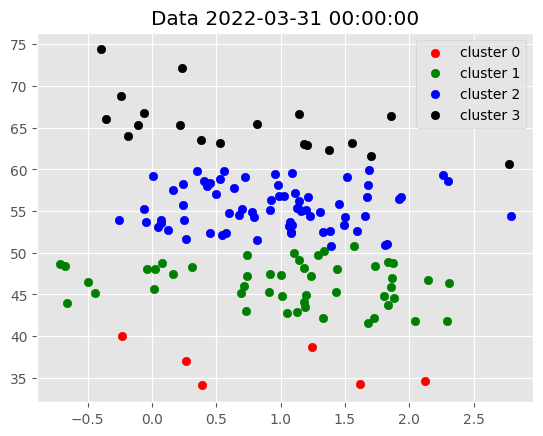

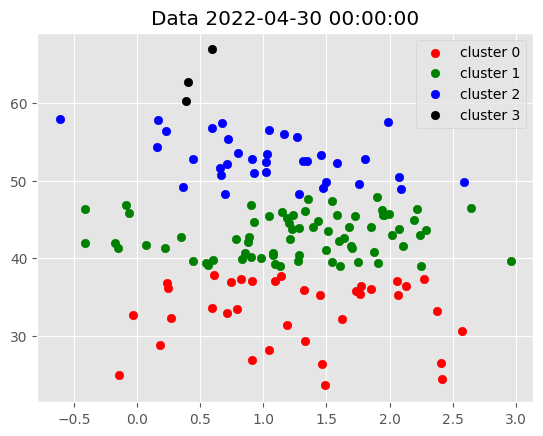

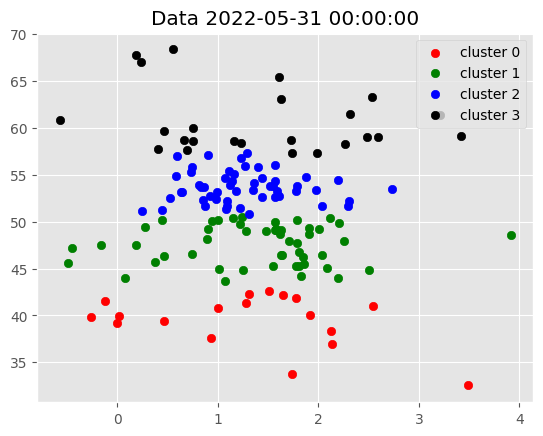

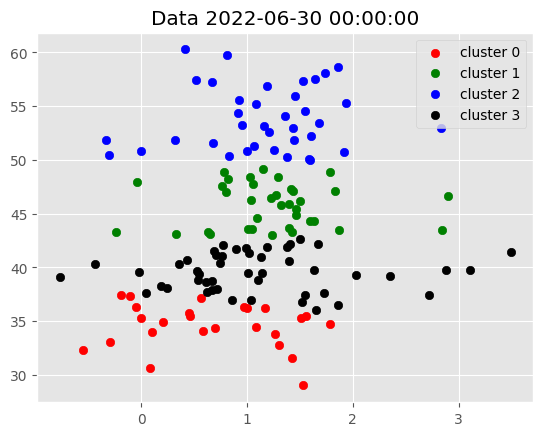

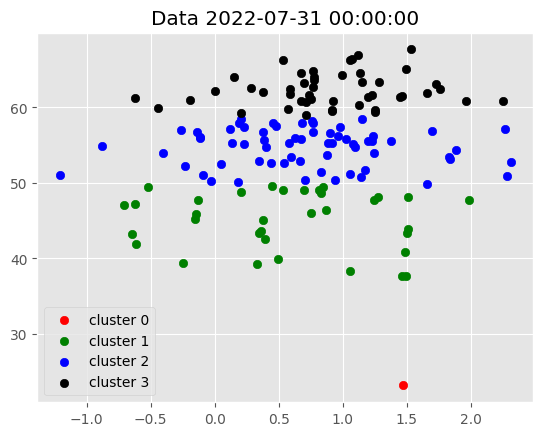

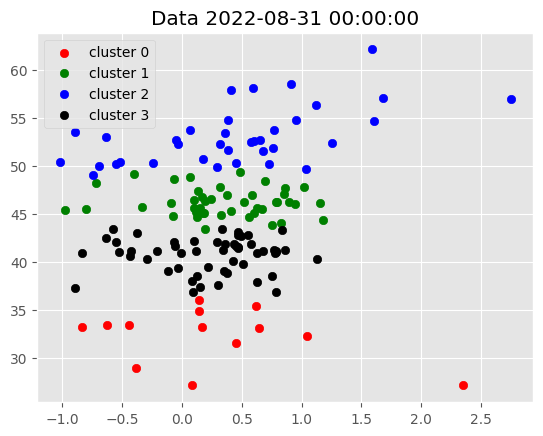

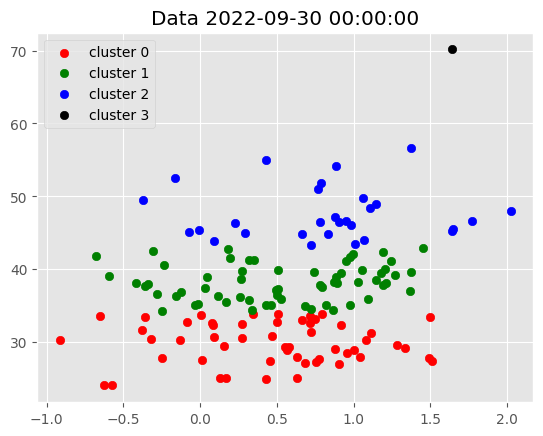

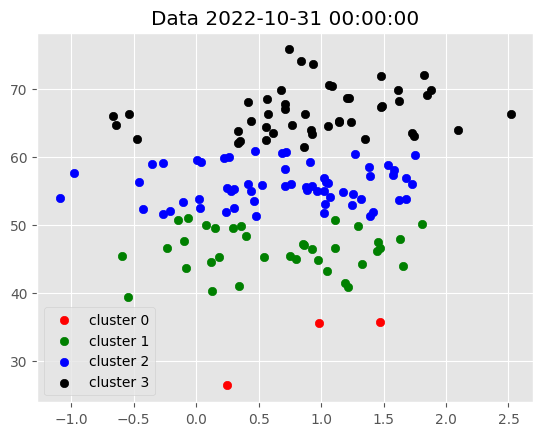

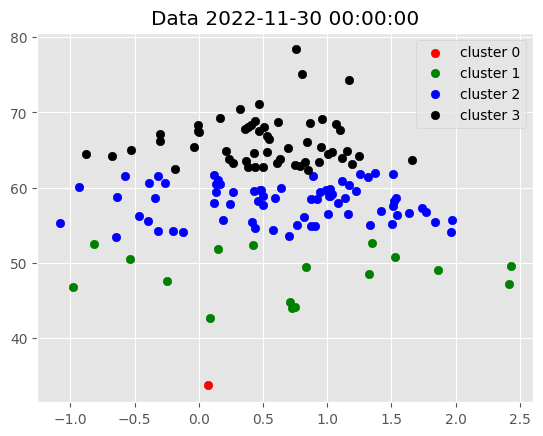

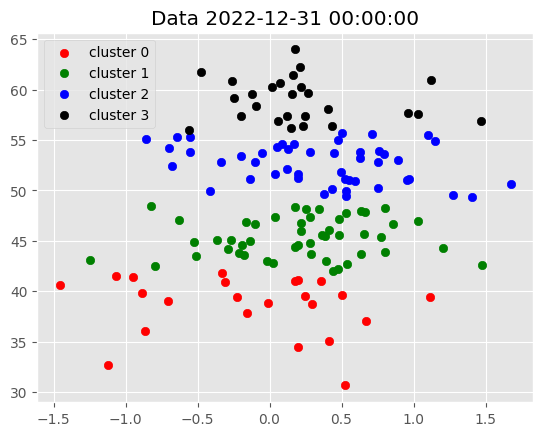

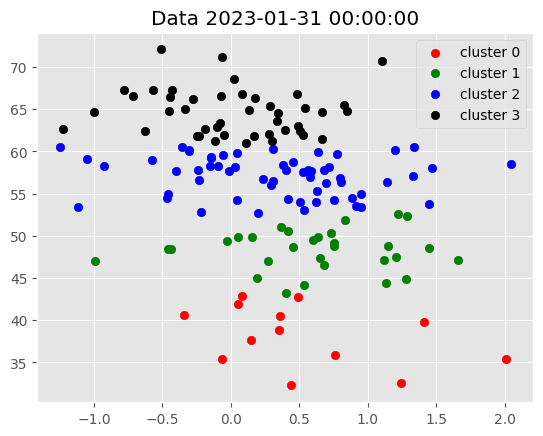

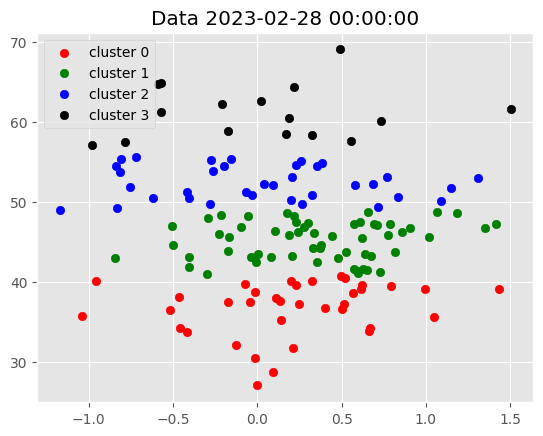

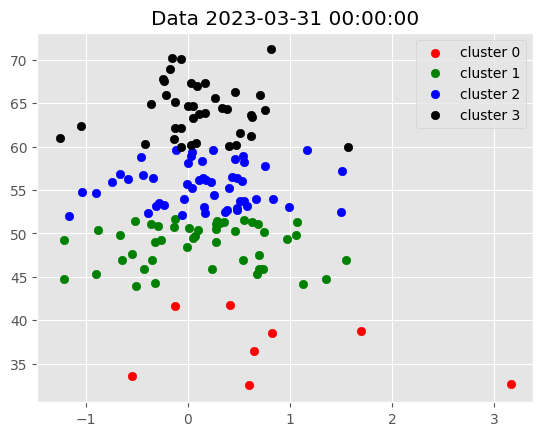

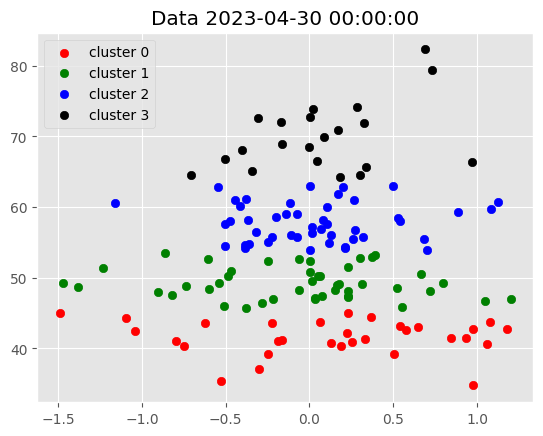

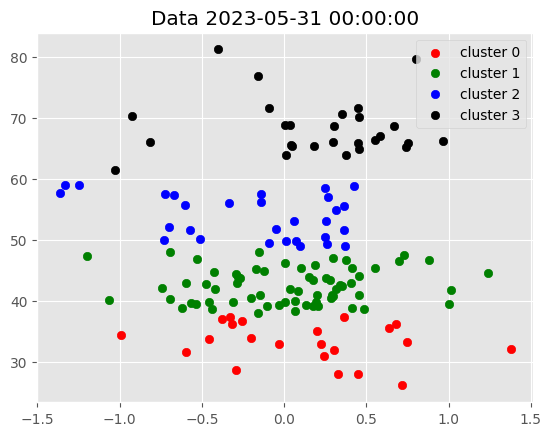

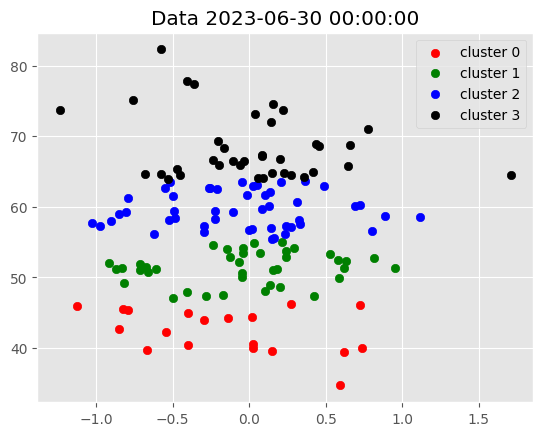

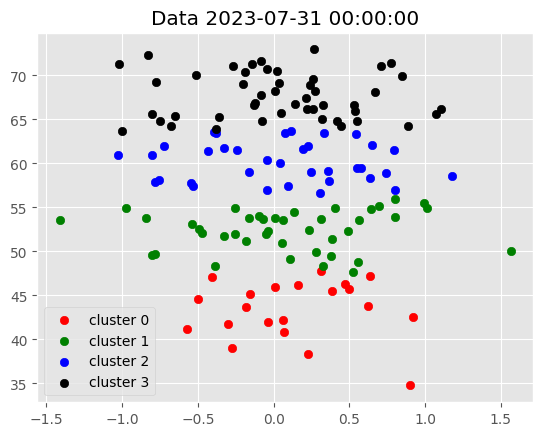

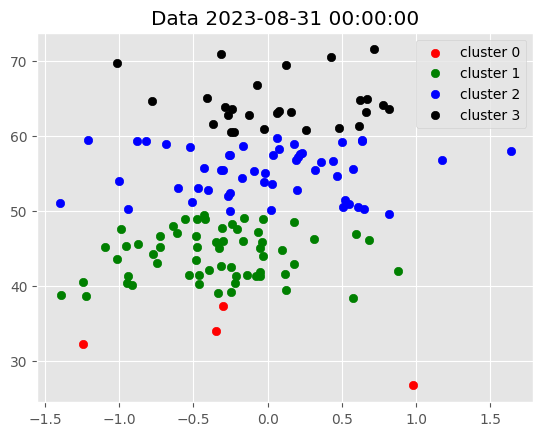

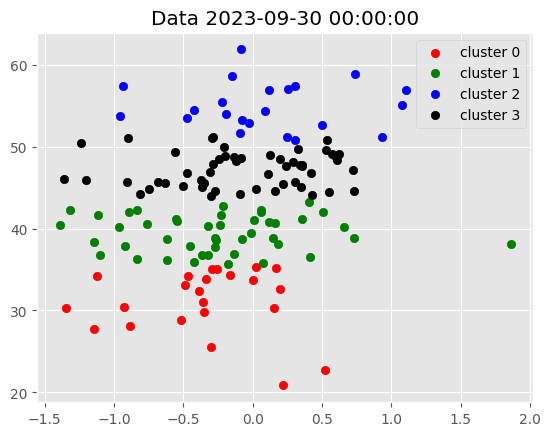

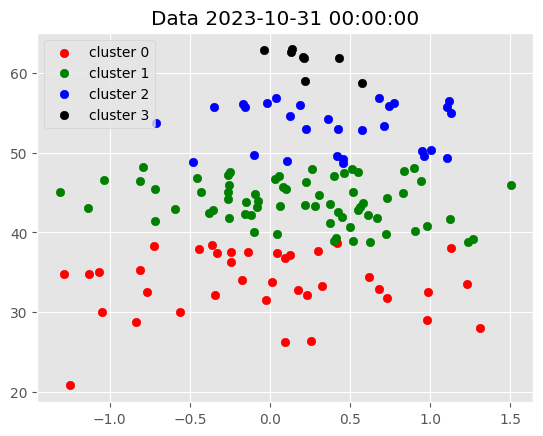

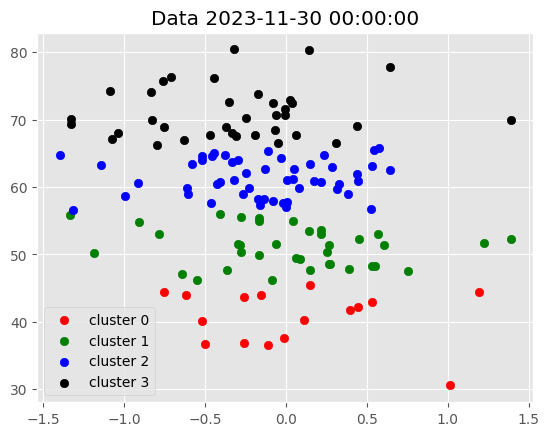

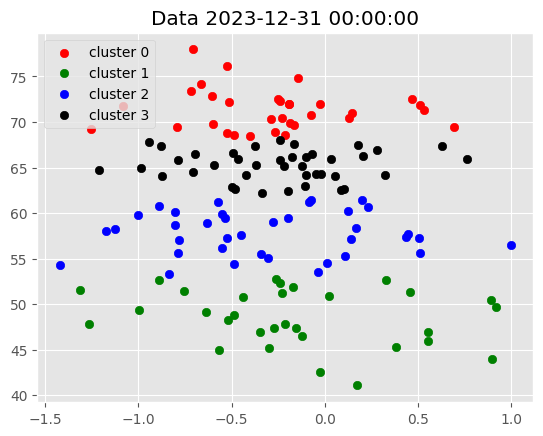

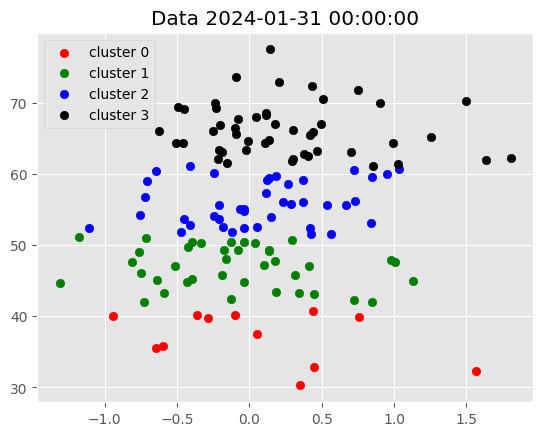

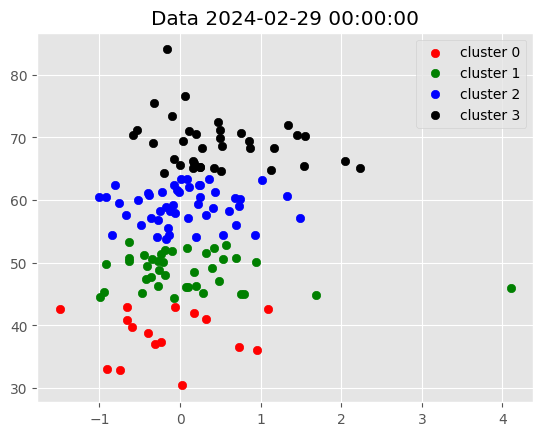

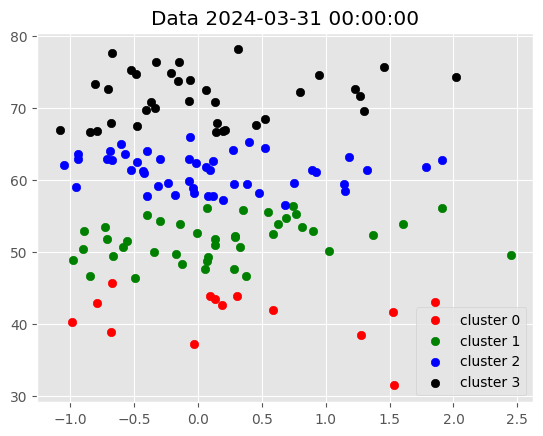

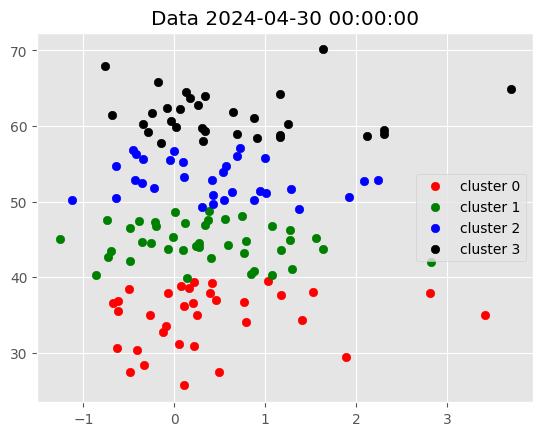

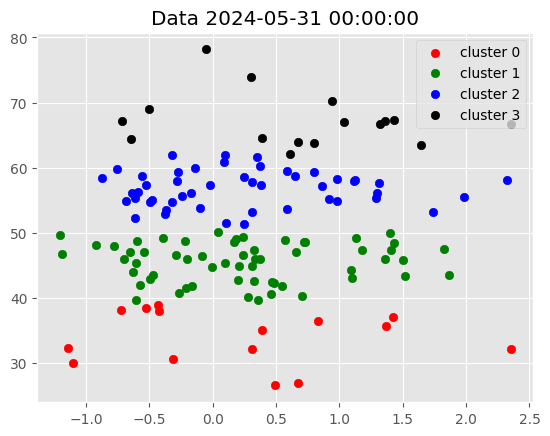

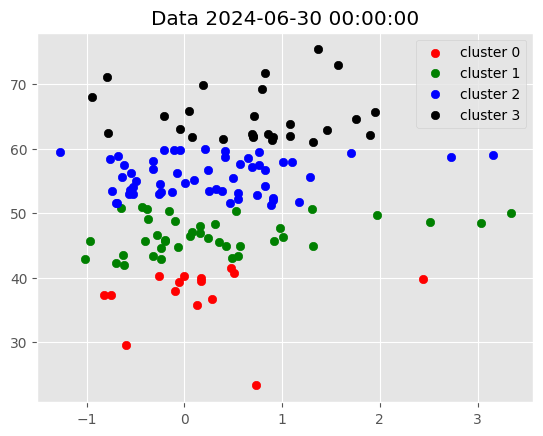

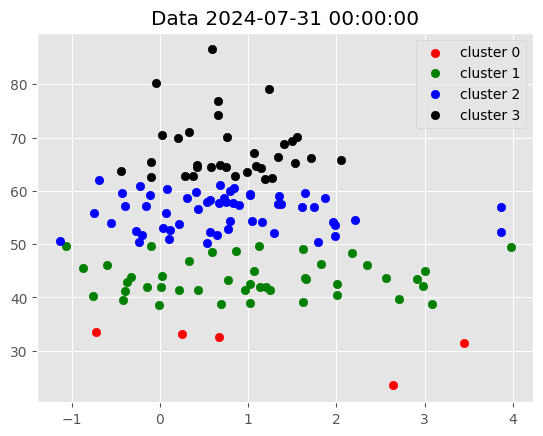

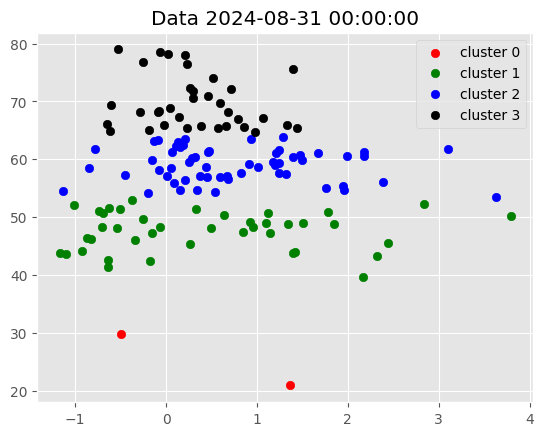

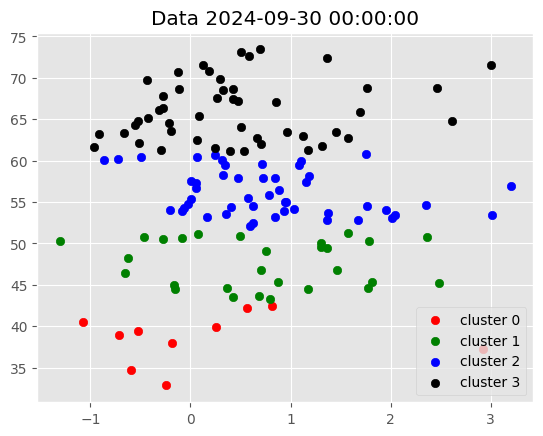

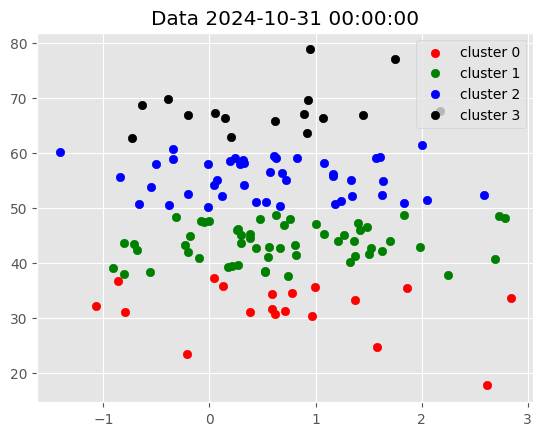

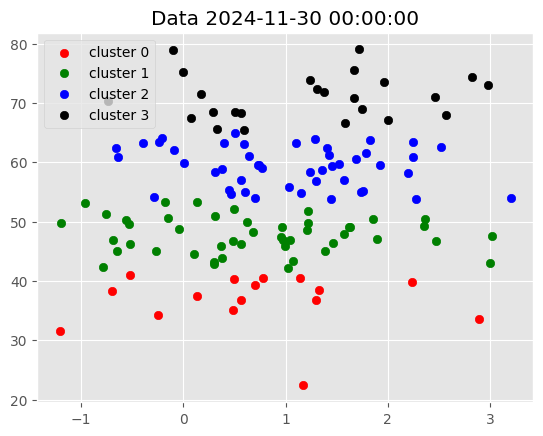

In [ ]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
  g = data.xs(i,level = 0)
  plt.title(f'Data {i}')
  plot_clusters(g)

**FOR EACH MONTH SELECT STOCKS BASED ON CLUSTERING**

In [ ]:
filtered_df = data[data['cluster']==3].copy()
filtered_df = filtered_df.reset_index(level=1)

In [ ]:
filtered_df.index = filtered_df.index + pd.DateOffset(1)


In [ ]:
 filtered_df = filtered_df.reset_index().set_index(['date','ticker'])

In [ ]:
dates =   filtered_df.index.get_level_values('date').unique().tolist()

# Extract unique dates from the 'date' level of the index
dates = filtered_df.index.get_level_values('date').unique().tolist()

# Initialize an empty dictionary to store the fixed dates
fixed_dates = {}

# Loop through the extracted dates
for d in dates:
    # Format the date and map it to the corresponding filtered index values
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

# Display the resulting dictionary
fixed_dates

{'2019-01-01': ['AAPL',
  'ACN',
  'AXP',
  'BAC',
  'CHTR',
  'CI',
  'CMCSA',
  'COST',
  'CSX',
  'DAL',
  'EA',
  'EXPE',
  'FCX',
  'GILD',
  'HON',
  'HUM',
  'IBM',
  'JNJ',
  'JPM',
  'LMT',
  'MCK',
  'META',
  'MS',
  'MU',
  'OXY',
  'T',
  'TGT',
  'TJX',
  'ULTA',
  'UPS',
  'VLO',
  'WFC'],
 '2019-02-01': ['ADI',
  'ADSK',
  'AMAT',
  'AMD',
  'AMT',
  'AVGO',
  'BA',
  'BDX',
  'C',
  'CHTR',
  'CMG',
  'CSCO',
  'DG',
  'DHR',
  'DLTR',
  'EBAY',
  'ELV',
  'GE',
  'GM',
  'IBM',
  'LRCX',
  'LUV',
  'MA',
  'MCK',
  'MDLZ',
  'META',
  'MGM',
  'NKE',
  'NXPI',
  'ORCL',
  'PANW',
  'PG',
  'REGN',
  'SBUX',
  'SHW',
  'TJX',
  'USB',
  'VLO',
  'WYNN'],
 '2019-03-01': ['ABT',
  'ACN',
  'ADBE',
  'ADI',
  'ADP',
  'ADSK',
  'AMT',
  'AXP',
  'AZO',
  'BA',
  'BLK',
  'CHTR',
  'CMG',
  'CRM',
  'CSCO',
  'CSX',
  'DHR',
  'EBAY',
  'HON',
  'IBM',
  'INTC',
  'INTU',
  'LLY',
  'LMT',
  'LOW',
  'MA',
  'MAR',
  'MRK',
  'NEE',
  'NKE',
  'NOC',
  'ORCL',
  'PANW',
  

##  Portfolio Optimization (Max Sharpe Ratio)  
**Theory**:  
- **Efficient Frontier**: Maximizes returns for given risk (PyPortfolioOpt).  
- **Weights**: Allocated to stocks in the highest-momentum cluster (Cluster 3).  



In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [ ]:
def optimize_weights(prices,lower_bound = 0):
  returns = expected_returns.mean_historical_return(prices = prices,
                                                     frequency = 252)

  cov = risk_models.sample_cov(prices , frequency = 252)

  ef = EfficientFrontier(returns,cov,weight_bounds=(lower_bound , .1),solver='SCS')
  weights = ef.max_sharpe()
  return ef.clean_weights()

In [ ]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers = stocks,
                     start = data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end = data.index.get_level_values('date').unique()[-1])
new_df

[*********************100%***********************]  153 of 153 completed


Price        Adj Close                                                  \
Ticker            AAPL        ABBV         ABT         ACN        ADBE   
Date                                                                     
2018-01-02   40.524342   72.345779   52.048271  138.659607  177.699997   
2018-01-03   40.517284   73.477913   52.163364  139.299561  181.039993   
2018-01-04   40.705490   73.058891   52.074825  140.948990  183.220001   
2018-01-05   41.168934   74.330673   52.225342  142.111633  185.339996   
2018-01-08   41.016033   73.139725   52.074825  143.247345  185.039993   
...                ...         ...         ...         ...         ...   
2024-11-22  229.869995  176.949997  117.760002  358.660004  512.150024   
2024-11-25  232.869995  177.059998  118.129997  361.290009  518.729980   
2024-11-26  235.059998  181.139999  117.959999  363.179993  525.299988   
2024-11-27  234.929993  183.080002  118.949997  362.160004  513.679993   
2024-11-29  237.330002  182.929993  118.769997  362.369995  515.929993   

Price                                                                   ...  \
Ticker             ADI         ADP        ADSK        ALGN        AMAT  ...   
Date                                                                    ...   
2018-01-02   79.129028  100.113739  107.120003  224.619995   49.034470  ...   
2018-01-03   80.110703  101.201263  109.379997  231.199997   49.903481  ...   
2018-01-04   80.023064  102.167961  112.070000  233.300003   50.190079  ...   
2018-01-05   80.347359  102.107544  110.839996  241.070007   50.476658  ...   
2018-01-08   80.487595  101.796822  111.419998  248.899994   51.696972  ...   
...                ...         ...         ...         ...         ...  ...   
2024-11-22  213.685211  303.576996  321.269989  225.889999  174.880005  ...   
2024-11-25  222.637314  303.099518  319.390015  240.520004  174.550003  ...   
2024-11-26  218.126419  306.382477  317.959991  227.929993  173.199997  ...   
2024-11-27  216.254349  305.337891  290.640015  229.660004  171.320007  ...   
2024-11-29  217.130630  305.347839  291.899994  232.770004  174.710007  ...   

Price        Volume                                                   \
Ticker          VLO     VRTX        VZ       WBA      WDAY       WDC   
Date                                                                   
2018-01-02  3582900  1382000  16045300   6605000   1599600   3894000   
2018-01-03  3057600  1604000  16662400   7147300   2047900   3253300   
2018-01-04  2977000  1345100  12062800  12456000   2774000   5173100   
2018-01-05  2973800  1940000  13348900   9067200   1025400   2727400   
2018-01-08  2493400  1987000  16212700   5312500   1626600   4875300   
...             ...      ...       ...       ...       ...       ...   
2024-11-22  2375200  1270400  17017400  20106600   1997700   5180900   
2024-11-25  4237200  2168200  28365900  29645100   3352900   8819000   
2024-11-26  1728600  1327700  17247000  17438100   4189900  10728100   
2024-11-27  1907000  1006900  12372400  13827900  13910300  10284500   
2024-11-29  1554100   770600   9023100  10057000   2733700   2756300   

Price                                              
Ticker           WFC       WMT     WYNN       XOM  
Date                                               
2018-01-02  13819300  30451500  2581200  11469300  
2018-01-03  14203700  26710800  3530900  13957700  
2018-01-04  18740500  20491200  2708800  10863000  
2018-01-05  14217900  21852000  2186600  11047600  
2018-01-08  15569400  26531700  1803800  10927100  
...              ...       ...      ...       ...  
2024-11-22  14997400  23990600  1620000  13323400  
2024-11-25  28636600  25078600  3055000  26580300  
2024-11-26  19139100  16657000  1807500  14827300  
2024-11-27  19793900  14358900  1436600  11079100  
2024-11-29   9785000  11041200  1402500   9426500  

[1740 rows x 918 columns]

In [ ]:
optimization_df = new_df['2018-01-01': '2018-12-31' ]['Adj Close'][fixed_dates['2019-01-01']]

Max Sharpe Optimization failed for 2020-03-01 , Continuing with Equal Weights
Max Sharpe Optimization failed for 2020-04-01 , Continuing with Equal Weights
Max Sharpe Optimization failed for 2020-06-01 , Continuing with Equal Weights
Max Sharpe Optimization failed for 2021-02-01 , Continuing with Equal Weights
Max Sharpe Optimization failed for 2021-10-01 , Continuing with Equal Weights
Max Sharpe Optimization failed for 2022-05-01 , Continuing with Equal Weights
Max Sharpe Optimization failed for 2022-09-01 , Continuing with Equal Weights
Max Sharpe Optimization failed for 2022-10-01 , Continuing with Equal Weights
Max Sharpe Optimization failed for 2023-11-01 , Continuing with Equal Weights
'return'


<Axes: xlabel='date'>

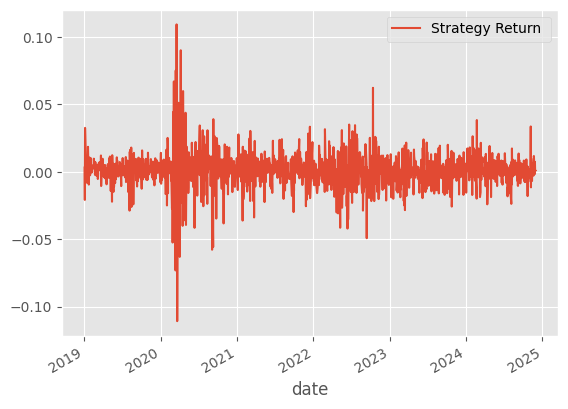

In [ ]:
returns_df = np.log(new_df['Adj Close']).diff()
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
  try:
    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

    cols = fixed_dates[start_date]

    optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
    optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days = 1)).strftime('%Y-%m-%d')

    optimization_df = new_df[optimization_start_date:optimization_end_date  ]['Adj Close'] [cols]
    success = False
    try:
      weights = optimize_weights(prices = optimization_df, lower_bound=0.011)
      weights = pd.DataFrame(weights,index=pd.Series(0))
      success = True
    except:
      print(f'Max Sharpe Optimization failed for {start_date} , Continuing with Equal Weights')

    if success == False:
      weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],index = optimization_df.columns.to_list(),columns=pd.Series(0)).T


    temp_df = returns_df[start_date:end_date]
    temp_df = temp_df.stack().to_frame('return').reset_index(level = 0)\
          .merge(weights.stack().to_frame('weight').reset_index(level=0,drop=True),
                  left_index = True,
                  right_index=True)\
                .reset_index().set_index(['Date','Ticker']).unstack().stack()
    temp_df.index.names = ['date','ticker']
    temp_df['weighted_returns'] = temp_df['return']*temp_df['weight']
    temp_df = temp_df.groupby(level=0)['weighted_returns'].sum().to_frame('Strategy Return ')
    portfolio_df = pd.concat([portfolio_df,temp_df],axis=0)
  except Exception as e:
    print(e)

portfolio_df.plot()

**8. Visualize and compare to SP500 returns**



---



In [ ]:
spy = yf.download(tickers = 'SPY',start = '2015-01-01',end=dt.date.today())
spy

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY,SPY
Date,,,,,,
2015-01-02,172.592880,205.429993,206.880005,204.179993,206.380005,121465900
2015-01-05,169.475922,201.720001,204.369995,201.350006,204.169998,169632600
2015-01-06,167.879578,199.820007,202.720001,198.860001,202.089996,209151400
2015-01-07,169.971573,202.309998,202.720001,200.880005,201.419998,125346700
2015-01-08,172.987778,205.899994,206.160004,203.990005,204.009995,147217800
...,...,...,...,...,...,...
2024-12-24,601.299988,601.299988,601.340027,595.469971,596.059998,33160100
2024-12-26,601.340027,601.340027,602.479980,598.080017,599.500000,41219100


In [ ]:
spy_ret = np.log(spy['Adj Close']).diff().dropna().rename({'Adj Close' : 'SPY Buy&Hold'},axis=1)
spy_ret

Ticker,SPY
Date,
2015-01-05,-0.018225
2015-01-06,-0.009464
2015-01-07,0.012384
2015-01-08,0.017590
2015-01-09,-0.008046
...,...
2024-12-24,0.011054
2024-12-26,0.000067
2024-12-27,-0.010582


In [ ]:
portfolio_df = portfolio_df.merge(spy_ret,left_index=True,right_index=True)
portfolio_df

,Strategy Return,SPY
2019-01-02,0.003066,0.001039
2019-01-03,-0.020916,-0.024152
2019-01-04,0.032437,0.032947
2019-01-07,0.015363,0.007854
2019-01-08,0.008101,0.009351
...,...,...
2024-11-22,0.007947,0.003095
2024-11-25,-0.001833,0.003386
2024-11-26,0.007261,0.005208
2024-11-27,0.000465,-0.003035


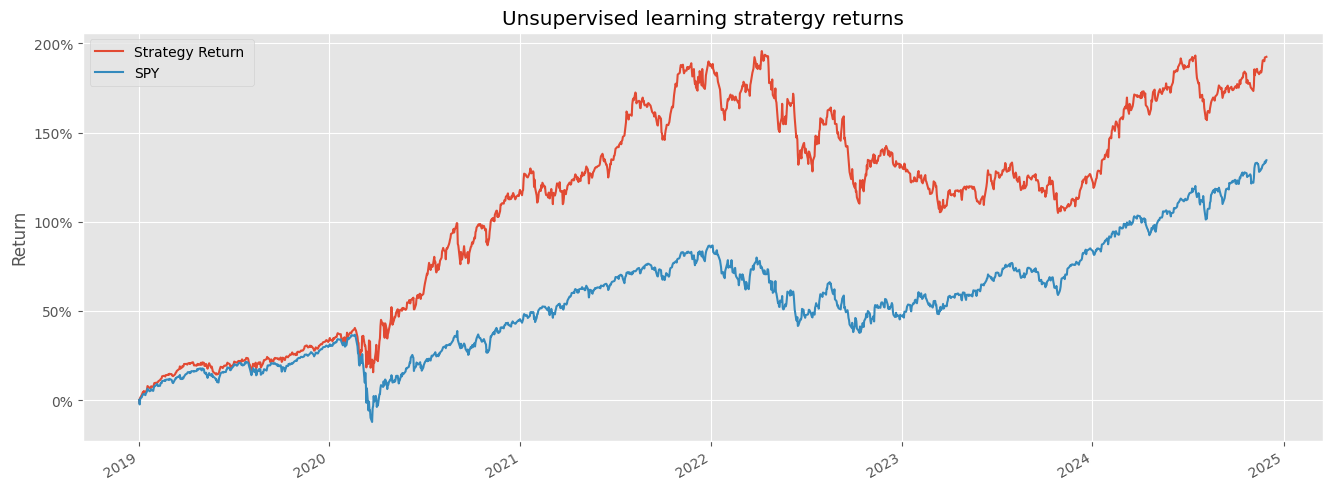

In [ ]:
plt.style.use('ggplot')
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()) - 1
portfolio_cumulative_return[:'2024-12-31'].plot(figsize=(16,6))
plt.title('Unsupervised learning stratergy returns')
# Use 'yaxis.set_major_formatter' instead of 'yaxis_set_major_formatter'
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1))
plt.ylabel('Return')

plt.show()

 Outperforms SPY in backtested period (2019–2024).  

## Conclusion  
- **Strengths**: Combines unsupervised learning with quantitative finance.  
- **Limitations**: Assumes no transaction costs; sensitive to cluster initialization.  
